# Relazione 10

## Esercizio 10.1:  Simulated annealing
In questa parte dell'esercitazione affrontiamo il problema del commesso viaggiatore con il metodo del simulated annealing. Analogamente agli algoritmi genetici, questa tecnica prende spunto da un processo naturale: se un sistema liquido viene raffreddato lentamente tende a formare un cristallo. La natura ha quindi la sorprendente proprietà di sapere trovare lo stato a minore energia del sistema se il raffreddamento è abbastanza lento.

Se consideriamo come energia fittizia del nostro sistema la funzione di costo $L_2(\vec{x})$, avremo che la probabilità associata a uno specifico stato (quindi a una permutazione) è data dalla distribuzione di Boltzmann
$$
p(\vec{x})=\frac{e^{-\beta L_2(\vec{x}}}{Z}
$$
e nel limite $T\rightarrow 0/\beta\rightarrow\infty$ la distribuzione è sempre più concentrata sullo stato fondamentale.

La schematizzazione del problema è simile a quella dell'esercitazione 9: i possibili percorsi sono rappresentati da un vettore di interi (che indica l'ordine in cui vengono visitate le città). Ci sono tre mutazioni possibili che agiscono sui vettori:
- permutazione di due elementi del vettore (selezionati casualmente)
- permutazione di due blocchi di elementi del vettore (anche in questo caso selezionati casualmente)
- inversione di una sezione casuale della permutazione

Durante la simulazione, una variabile che rappresenta la temperatura viene diminuita di un valore fisso $\Delta T$ a partire da una certa temperatura iniziale $T_0$. A differenza del codice genetico, in cui abbiamo una popolazione di permutazioni, si considera una sola permutazione per volta. Ad ogni step di temperatura, per $n_{step}$ volte si ottiene una nuova permutazione a partire da quella attuale applicando ciascuna delle mutazioni sopra descritte. La nuova permutazione può sostituire quella precedente con una probabilità pari a

- $100\%$ se $L_2(\vec{x}_{new})<L_2(\vec{x}_{old})$
- $\exp(-\beta(L_2(\vec{x}_{new})-L_2(\vec{x}_{old}))$ altrimenti

Anche in questo caso abbiamo studiato $32$ città distribuite su di una circonferenza o uniformemente in un quadrato. Riportiamo i risultati ottenuti tramite un grafico del costo della permutazione in funzione di $T_0-T$ (proporzionale al numero di step di temperatura calcolati) e rappresentando il percorso finale.

### Città distribuite su di una circonferenza

parametri della simulazione:
- $n_{step}=100$ steps
- $T_0$=10
- $\Delta T$=0.002

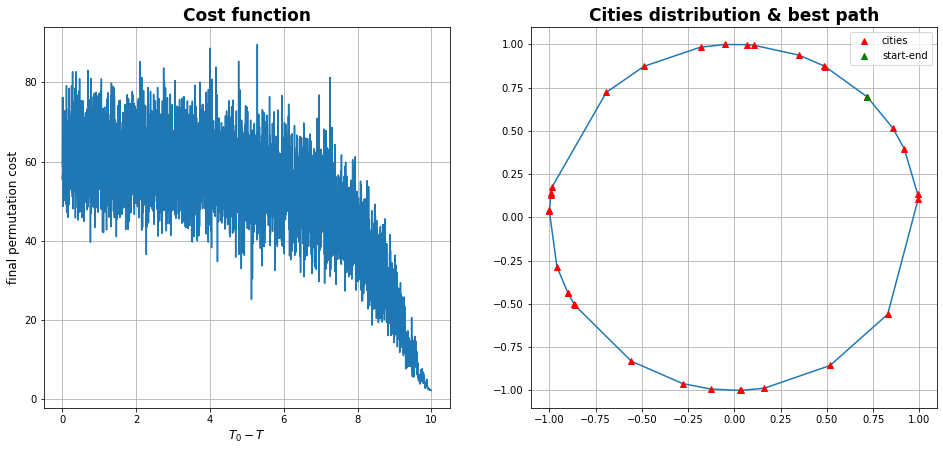

In [9]:
import matplotlib.pyplot as plt
import numpy as np

T0 = 10.
T, cost = np.loadtxt('circle/evolution.dat',unpack=True)

plt.figure(figsize=(16,7))
plt.subplot(121)
plt.plot(T0-T,cost)
plt.xlabel('$T_0-T$',fontsize=12)
plt.ylabel('final permutation cost',fontsize=12)
plt.title("Cost function",fontsize=17,fontweight='bold')
plt.grid(True)

x,y = np.loadtxt("circle/bestpath.dat", unpack=True)
x = np.append(x, x[0])
y = np.append(y, y[0])

plt.subplot(122)
plt.plot(x,y)
plt.plot(x,y,'r^',label='cities')
plt.plot(x[0],y[0],'g^',label='start-end')
plt.grid(True)
plt.title('Cities distribution & best path',fontweight='bold',fontsize=17)

plt.legend()
plt.show()

La permutazione ottenuta corrisponde alla migliore.

### Città distribuite in un quadrato

parametri della simulazione:
- $n_{steps}=300$
- $T_0=7.5$
- $\Delta T=0.0002$

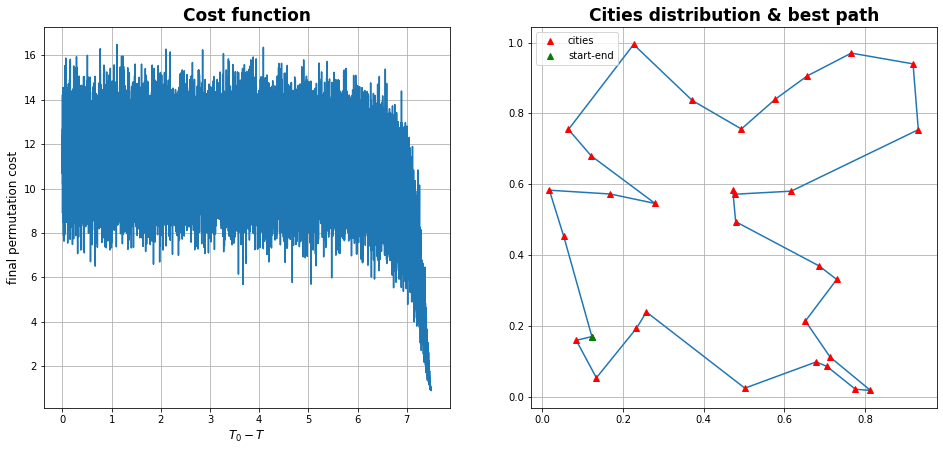

final cost:  0.915372


In [13]:
T0 = 7.5
T, cost = np.loadtxt('square/evolution.dat',unpack=True)

plt.figure(figsize=(16,7))
plt.subplot(121)
plt.plot(T0-T,cost)
plt.xlabel('$T_0-T$',fontsize=12)
plt.ylabel('final permutation cost',fontsize=12)
plt.title("Cost function",fontsize=17,fontweight='bold')
plt.grid(True)

x,y = np.loadtxt("square/bestpath.dat", unpack=True)
x = np.append(x, x[0])
y = np.append(y, y[0])

plt.subplot(122)
plt.plot(x,y)
plt.plot(x,y,'r^',label='cities')
plt.plot(x[0],y[0],'g^',label='start-end')
plt.grid(True)
plt.title('Cities distribution & best path',fontweight='bold',fontsize=17)

plt.legend()
plt.show()

print('final cost: ',cost[cost.size-1])

Con questa tecnica abbiamo trovato una soluzione di poco peggiore ($0.1\%$) rispetto a quanto ottenuto con il codice genetico.

## 10.2: Calcolo Parallelo
In questa sezione proviamo invece a parallelizzare l'esecuzione di un programma in cui il problema del commesso viaggiatore è affrontato con un algoritmo genetico. L'implementazione sfrutta la libreria MPI.

Creiamo quindi 4 popolazioni su 4 diversi "continenti", in cui l'evoluzione si sviluppa indipendentemente. Ogni $N_{migr}$ generazioni, i continenti vengono accoppiati in maniera casuale e si scambiano a vicenda il miglior elemento della popolazione.

Il modello seguito è SPMD (Single Program Multiple Data): il programma eseguito è lo stesso, ma il suo comportamento viene in qualche modo diversificato tra i vari processi. Nello specifico, inizializziamo un generatore di numeri casuali con un seed differente per ciascun processo (questo viene nella pratica implementato utilizzando il valore della variabile rank, che identifica il processo). Il generatore viene utilizzato negli operatori di mutazione e di selezione, e per campionare una distribuzione di probabilità uniforme (e quindi per decidere se un processo con una certa probabilità avvenga o no): la sequenza di numeri casuali restituta è quindi determinante per l'evoluzione della popolazione. Abbiamo conferma di questo fatto nel momento in cui rappresentiamo in maniera grafica la funzione di costo del miglior elemento della popolazione per ciascun continente: l'andamento è diverso per diversi generatori. È altresì necessario istanziare anche un generatore di numeri (pseudo)casuali comune a tutti i processi, che viene utilizzato per generare la disposizione delle città (che chiaramente devono essere le stesse perché il confronto tra i continenti abbia significato) e per la selezione dei continenti che si scambiano l'elemento migliore.

Abbiamo mantenuto gli operatori di selezione, di crossover e di mutazione del codice genetico sviluppato per l'esercitazione 9. Anche i parametri sono identici:
- $p_{crossover}=0.7$
- $p_{mutation 1}=0.09$
- $p_{mutation 2}=0.1$
- $p_{mutation 3}=0.1$
- Elementi (cromosomi) nella popolazione $=10^3$

Riportiamo in un unico grafico l'andamento della funzione di costo $L_2(\vec{x})$ nei vari continenti, e in ua seconda figura il miglior percorso ottenuto in ciascuno dei continenti.

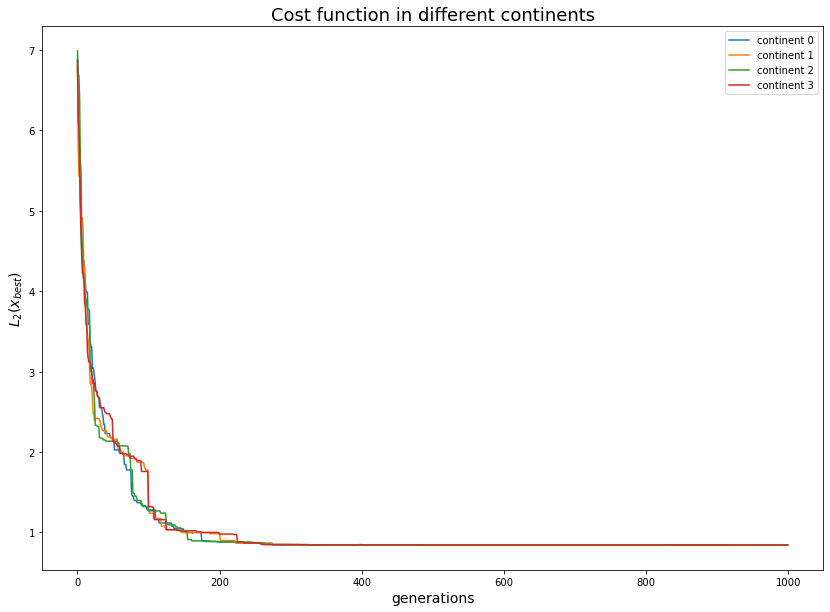

continent 0: best cost =  0.842859
continent 1: best cost =  0.84319
continent 2: best cost =  0.842399
continent 3: best cost =  0.84319


In [18]:
import matplotlib.pyplot as plt
import numpy as np

c0=np.loadtxt('parallel_data/best0.dat')
c1=np.loadtxt('parallel_data/best1.dat')
c2=np.loadtxt('parallel_data/best2.dat')
c3=np.loadtxt('parallel_data/best3.dat')
steps = np.arange(c0.size)

plt.figure(figsize=(14,10))
plt.plot(np.arange(c0.size),c0,label='continent 0')
plt.plot(np.arange(c1.size),c1,label='continent 1')
plt.plot(np.arange(c2.size),c2,label='continent 2')
plt.plot(np.arange(c3.size),c3,label='continent 3')
plt.legend()
plt.xlabel('generations',fontsize=14)
plt.ylabel('$L_2(x_{best})$',fontsize=14)
plt.title('Cost function in different continents',fontsize=18)

plt.show()

print('continent 0: best cost = ',c0[c0.size-1])
print('continent 1: best cost = ',c1[c1.size-1])
print('continent 2: best cost = ',c2[c2.size-1])
print('continent 3: best cost = ',c3[c3.size-1])

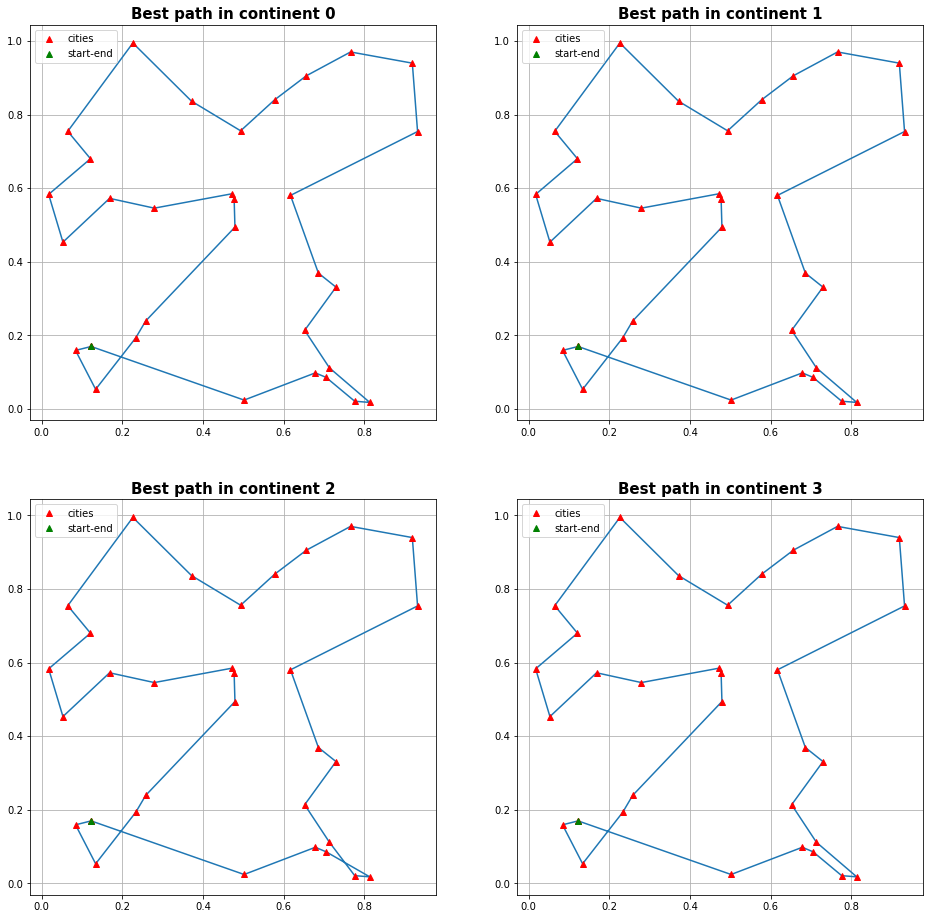

In [5]:
x0,y0 = np.loadtxt("parallel_data/bestpath0.dat", unpack=True)
x0 = np.append(x0, x0[0])
y0 = np.append(y0, y0[0])

plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(x0,y0)
plt.plot(x0,y0,'r^',label='cities')
plt.plot(x0[0],y0[0],'g^',label='start-end')
plt.grid(True)
plt.title('Best path in continent 0',fontweight='bold',fontsize=15)
plt.legend()

x1,y1 = np.loadtxt("parallel_data/bestpath1.dat", unpack=True)
x1 = np.append(x1, x1[0])
y1 = np.append(y1, y1[0])

plt.subplot(222)
plt.plot(x1,y1)
plt.plot(x1,y1,'r^',label='cities')
plt.plot(x1[0],y1[0],'g^',label='start-end')
plt.grid(True)
plt.title('Best path in continent 1',fontweight='bold',fontsize=15)
plt.legend()

x2,y2 = np.loadtxt("parallel_data/bestpath2.dat", unpack=True)
x2 = np.append(x2, x2[0])
y2 = np.append(y2, y2[0])

plt.subplot(223)
plt.plot(x2,y2)
plt.plot(x2,y2,'r^',label='cities')
plt.plot(x2[0],y2[0],'g^',label='start-end')
plt.grid(True)
plt.title('Best path in continent 2',fontweight='bold',fontsize=15)
plt.legend()

x3,y3 = np.loadtxt("parallel_data/bestpath3.dat", unpack=True)
x3 = np.append(x3, x3[0])
y3 = np.append(y3, y3[0])

plt.subplot(224)
plt.plot(x3,y3)
plt.plot(x3,y3,'r^',label='cities')
plt.plot(x3[0],y3[0],'g^',label='start-end')
plt.grid(True)
plt.title('Best path in continent 3',fontweight='bold',fontsize=15)
plt.legend()

Si osserva in questo caso un fenomeno interessante: seppur la simulazione non abbia trovato la permutazione migliore (di questo possiamo essere certi, poiché ci sono dei punti in cui la strada si incrocia: in questo caso, percorrere i lati del trapezio invece delle sue diagonali garantirebbe un percorso di lunghezza minore) abbiamo ottenuto delle permutazioni il cui costo è minore della miglior permutazione ottenuta nell'esercitazione 9 e nell'esercizio 10.1.
La riduzione è circa dell'$8\%$ (da 0.914 a 0.8424)
